In [2]:
parent_path = !(cd .. && echo $(pwd))

In [13]:
import sys
sys.path.insert(0,parent_path[0])

from __future__ import annotations

import chess
import numpy as np
import tensorflow as tf
from tensorflow import keras
import keras_nlp

In [4]:
board = chess.Board(fen="r3k2r/1p1b1ppp/nq2pn2/pN6/PbBP4/4P3/1B3PPP/R2Q1KNR w kq - 3 13")
print(board)

r . . . k . . r
. p . b . p p p
n q . . p n . .
p N . . . . . .
P b B P . . . .
. . . . P . . .
. B . . . P P P
R . . Q . K N R


In [5]:
pieces = [board.piece_at(square) for square in chess.SQUARES]
print(pieces[0])

R


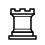

In [6]:
chess.Piece.from_symbol("R")

In [7]:
board.has_kingside_castling_rights(chess.WHITE)

False

In [8]:
board.turn

True

In [9]:
PIECE_ENCODING = {
    "empty": 16,
    "P": 17,
    "N": 18,
    "B": 19,
    "R": 20,
    "Q": 21,
    "K": 22,
    "p": 23,
    "n": 24,
    "b": 25,
    "r": 26,
    "q": 27,
    "k": 28,
    "turn_white": 29,
    "turn_black": 30,
    "no_castling": 31,
    "castling": 32
}

In [10]:
def encoding_from_piece(board: chess.Board) -> np.ndarray:
    pieces = [board.piece_at(square) for square in chess.SQUARES]
    encoding = np.zeros((64+5), dtype=np.int8)

    for i, piece in enumerate(pieces):
        encoding[i] = PIECE_ENCODING[piece.symbol() if piece is not None else "empty"]
    encoding[64] = PIECE_ENCODING["turn_white" if board.turn else "turn_black"]
    encoding[65] = PIECE_ENCODING["castling" if board.has_kingside_castling_rights(chess.WHITE) else "no_castling"]
    encoding[66] = PIECE_ENCODING["castling" if board.has_queenside_castling_rights(chess.WHITE) else "no_castling"]
    encoding[67] = PIECE_ENCODING["castling" if board.has_kingside_castling_rights(chess.BLACK) else "no_castling"]
    encoding[68] = PIECE_ENCODING["castling" if board.has_queenside_castling_rights(chess.BLACK) else "no_castling"]

    return encoding

In [11]:
encoding = encoding_from_piece(board)
print(encoding)

[20 16 16 21 16 22 18 20 16 19 16 16 16 17 17 17 16 16 16 16 17 16 16 16
 17 25 19 17 16 16 16 16 23 18 16 16 16 16 16 16 24 27 16 16 23 24 16 16
 16 23 16 25 16 23 23 23 26 16 16 16 28 16 16 26 29 31 31 32 32]


In [14]:
INVERSE_PIECE_ENCODING = {v:k for k,v in PIECE_ENCODING.items()}

def _piece_id_to_piece(id: int) -> chess.Piece | None:
	if 17 <= id <= 28:
		return chess.Piece.from_symbol(INVERSE_PIECE_ENCODING[id])
	return None

def token_sequence_to_board(sequence: np.ndarray) -> chess.Board:
	assert sequence.shape == (69,)
	board = chess.Board()
	board.clear()

	piece_map = {
		i: _piece_id_to_piece(piece_id)
		for i, piece_id in enumerate(sequence[:64])
		if _piece_id_to_piece(piece_id) is not None
	}
	board.set_piece_map(piece_map)
	
	board.turn = sequence[64] == 29
	castling_rights = ""
	if sequence[65] == 32: castling_rights += "K"
	if sequence[66] == 32: castling_rights += "Q"
	if sequence[67] == 32: castling_rights += "k"
	if sequence[68] == 32: castling_rights += "q"
	board.set_castling_fen(castling_rights)
	return board

In [17]:
reconstructed_board = token_sequence_to_board(encoding)
print(reconstructed_board)

r . . . k . . r
. p . b . p p p
n q . . p n . .
p N . . . . . .
P b B P . . . .
. . . . P . . .
. B . . . P P P
R . . Q . K N R


In [19]:
print(reconstructed_board.turn)
print(reconstructed_board.has_kingside_castling_rights(chess.WHITE))
print(reconstructed_board.has_queenside_castling_rights(chess.WHITE))
print(reconstructed_board.has_kingside_castling_rights(chess.BLACK))
print(reconstructed_board.has_queenside_castling_rights(chess.BLACK))

True
False
False
True
True


In [56]:
VOCAB_SIZE=64
SEQ_LEN=69
EMBED_DIM=256
NUM_LAYERS=2

In [57]:
inputs = keras.layers.Input(shape=(69,), dtype=tf.int8)
# Embedding.
embedding_layer = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=VOCAB_SIZE,
    sequence_length=SEQ_LEN,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)
x = embedding_layer(inputs)
# Transformer decoders.
for _ in range(NUM_LAYERS):
    decoder_layer = keras_nlp.layers.TransformerDecoder(
        num_heads=4,
        intermediate_dim=256,
    )
    x = decoder_layer(x)  # Giving one argument only skips cross-attention.
# Output.
outputs = keras.layers.Dense(VOCAB_SIZE)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
perplexity = keras_nlp.metrics.Perplexity(from_logits=True, mask_token_id=0)
model.compile(optimizer="adam", loss=loss_fn, metrics=[perplexity])

In [58]:
model.summary(expand_nested=True)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 69)]              0         
                                                                 
 token_and_position_embeddin  (None, 69, 256)          34048     
 g_1 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_decoder_1 (Tran  (None, 69, 256)          395776    
 sformerDecoder)                                                 
                                                                 
 transformer_decoder_2 (Tran  (None, 69, 256)          395776    
 sformerDecoder)                                                 
                                                                 
 dense_1 (Dense)             (None, 69, 64)            1644

In [59]:
bert_backbone = keras_nlp.models.BertBackbone.from_preset("bert_tiny_en_uncased")

In [60]:
bert_backbone.summary()

Model: "bert_backbone_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 token_ids (InputLayer)         [(None, None)]       0           []                               
                                                                                                  
 token_embedding (ReversibleEmb  (None, None, 128)   3906816     ['token_ids[0][0]']              
 edding)                                                                                          
                                                                                                  
 segment_ids (InputLayer)       [(None, None)]       0           []                               
                                                                                                  
 position_embedding (PositionEm  (None, None, 128)   65536       ['token_embedding[

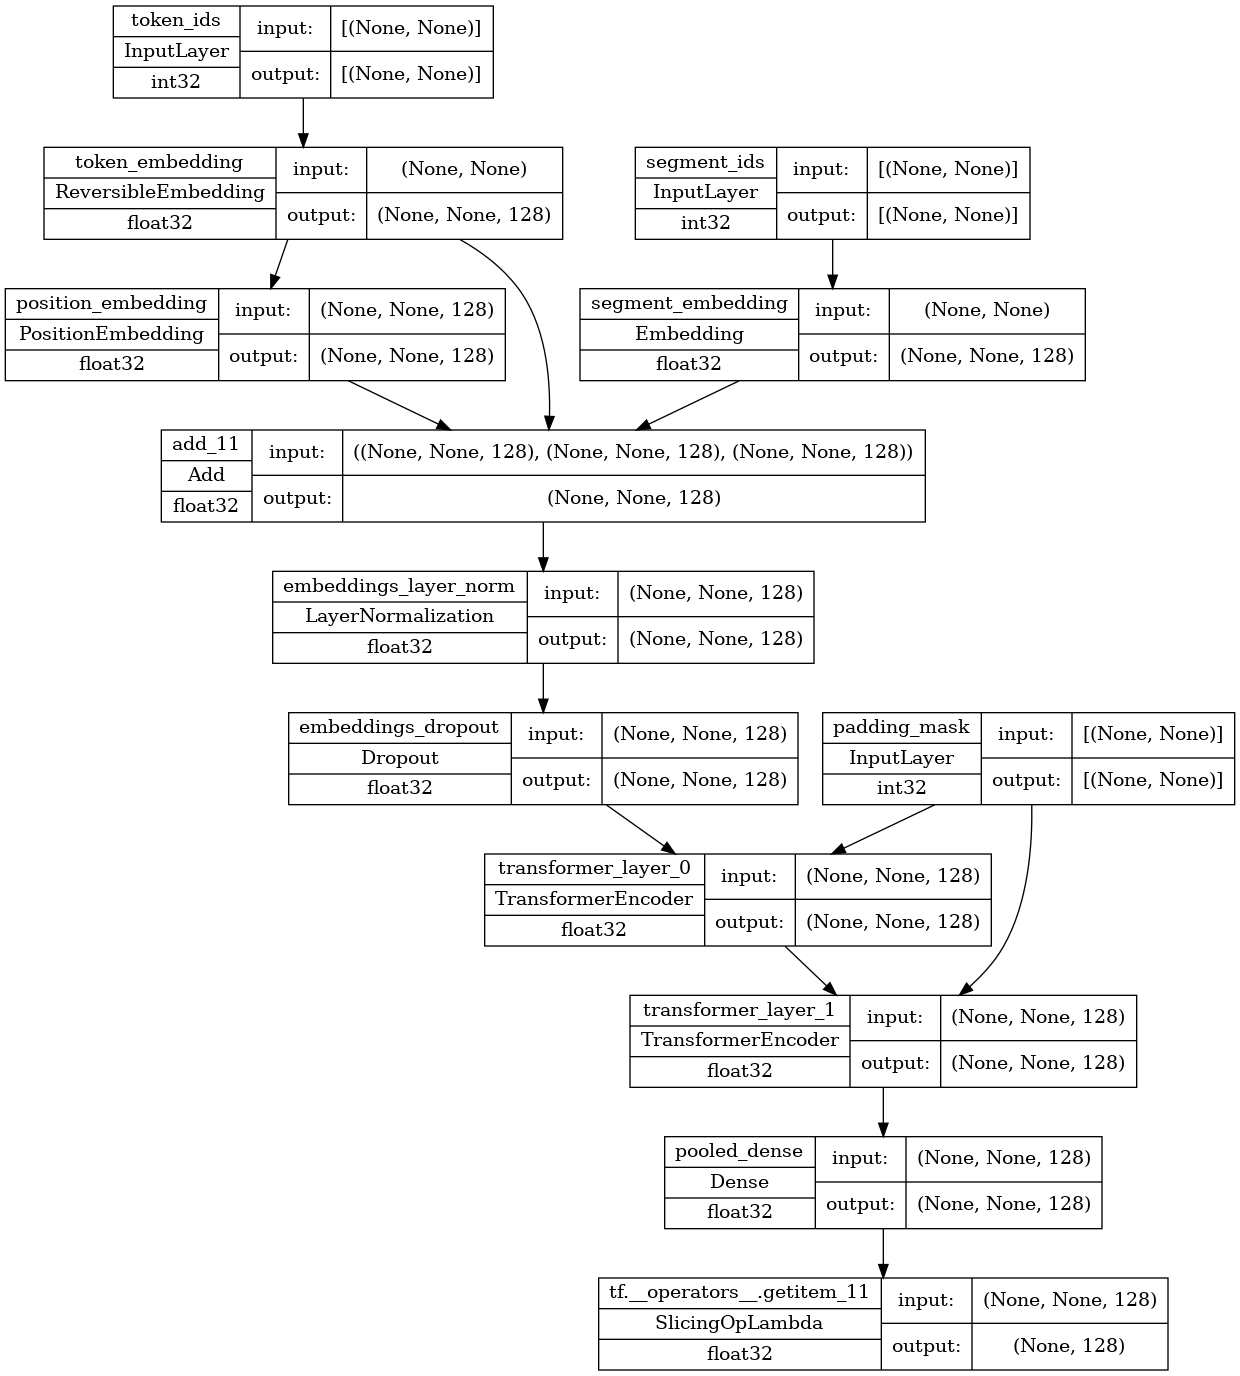

In [61]:
keras.utils.plot_model(bert_backbone, show_shapes=True, show_dtype=True, show_layer_names=True)

In [42]:
features = {
    "token_ids": np.array([[1, 2, 0, 4, 0, 6, 7, 8]] * 2),
    "padding_mask": np.array([[1, 1, 1, 1, 1, 1, 1, 1]] * 2),
    "mask_positions": np.array([[2, 4]] * 2),
    "segment_ids": np.array([[0, 0, 0, 0, 0, 0, 0, 0]] * 2)
}
# Labels are the original masked values.
labels = [[3, 5]] * 2

masked_lm = keras_nlp.models.BertMaskedLM.from_preset(
    "bert_tiny_en_uncased",
    preprocessor=None,
)
masked_lm.fit(x=features, y=labels, batch_size=2)

TypeError: predict() got an unexpected keyword argument 'y'

In [44]:
features["token_ids"], features["mask_positions"]

(array([[1, 2, 0, 4, 0, 6, 7, 8],
        [1, 2, 0, 4, 0, 6, 7, 8]]),
 array([[2, 4],
        [2, 4]]))

In [66]:
backbone = masked_lm.summary(expand_nested=True)

Model: "bert_masked_lm_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                           ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)                     │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ segment_ids (InputLayer)                      │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_ids (InputLayer)                        │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ bert_backbone_10 (BertBackbone)               │ {sequence_output: (None, None, 128),   │       4,385,920 │
│                                               │ pooled_output: (None, 128)}            │                 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│    └ token_ids (InputLayer)                   │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│    └ token_embedding (ReversibleEmbedding)    │ (None, None, 128)                      │       3,906,816 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│    └ segment_ids (InputLayer)                 │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│    └ position_embedding (PositionEmbedding)   │ (None, None, 128)                      │          65,536 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│    └ segment_embedding (Embedding)            │ (None, None, 128)                      │             256 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│    └ add_10 (Add)                             │ (None, None, 128)                      │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│    └ embeddings_layer_norm                    │ (None, None, 128)                      │             256 │
│ (LayerNormalization)                          │                                        │                 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│    └ embeddings_dropout (Dropout)             │ (None, None, 128)                      │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│    └ padding_mask (InputLayer)                │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│    └ transformer_layer_0 (TransformerEncoder) │ (None, None, 128)                      │         198,272 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│    └ transformer_layer_1 (TransformerEncoder) │ (None, None, 128)                      │         198,272 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│    └ pooled_dense (Dense)                     │ (None, None, 128)                      │          16,512 │
├───────────────────────────────────────────────┼───────────────────────────

 Total params: 4,433,210 (16.91 MB)

 Trainable params: 4,433,210 (16.91 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
prompt = {
    "token_ids": np.array([[5338, 318, 0, 0, 0]] * 2),
    "padding_mask": np.array([[1, 1, 0, 0, 0]] * 2),
}

gpt2_lm = keras_nlp.models.GPT2CausalLM.from_preset(
    "gpt2_base_en",
    preprocessor=None,
)
gpt2_lm.generate(prompt)

497986112/497986112 [==============================] - 114s 0us/step
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


{'token_ids': array([[ 5338,   318,   534, 12507,    30],
        [ 5338,   318,  1016,   284,  1592]]),
 'padding_mask': array([[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]])}

In [50]:
gpt2_lm.summary(expand_nested=True)

Model: "gpt2_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                           ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)                     │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_ids (InputLayer)                        │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ gpt2_backbone (GPT2Backbone)                  │ (None, None, 768)                      │     124,439,808 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│    └ token_ids (InputLayer)                   │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│    └ token_embedding (ReversibleEmbedding)    │ (None, None, 50257)                    │      38,597,376 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│    └ position_embedding (PositionEmbedding)   │ (None, None, 768)                      │         786,432 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│    └ embeddings_add (Add)                     │ (None, None, 768)                      │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│    └ embeddings_dropout (Dropout)             │ (None, None, 768)                      │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│    └ padding_mask (InputLayer)                │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│    └ transformer_layer_0 (TransformerDecoder) │ (None, None, 768)                      │       7,087,872 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│    └ transformer_layer_1 (TransformerDecoder) │ (None, None, 768)                      │       7,087,872 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│    └ transformer_layer_2 (TransformerDecoder) │ (None, None, 768)                      │       7,087,872 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│    └ transformer_layer_3 (TransformerDecoder) │ (None, None, 768)                      │       7,087,872 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│    └ transformer_layer_4 (TransformerDecoder) │ (None, None, 768)                      │       7,087,872 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│    └ transformer_layer_5 (TransformerDecoder) │ (None, None, 768)                      │       7,087,872 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│    └ transformer_layer_6 (TransformerDecoder) │ (None, None, 768)                      │       7,087,872 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│    └ transformer_layer_7 (TransformerDecoder) │ (None, None, 768)                      │       7,087,872 │
├───────────────────────────────────────────────┼───────────────────────────

 Total params: 124,439,808 (474.70 MB)

 Trainable params: 124,439,808 (474.70 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
batch_size = 1
vocab_size = 32
hidden_dim = 32
seq_length = 50

# Generate random inputs.
token_ids = np.random.randint(vocab_size, size=(batch_size, seq_length))

print(token_ids)

embedding = keras_nlp.layers.ReversibleEmbedding(vocab_size, hidden_dim)
# Embed tokens to shape `(batch_size, seq_length, hidden_dim)`.
hidden_states = embedding(token_ids)
# Project hidden states to shape `(batch_size, seq_length, vocab_size)`.
logits = embedding(hidden_states, reverse=True)

print(tf.shape(logits))
print(tf.argmax(logits, 1))

[[12  4  1 28 18  9 22 20  6 28 11  0 19 18  0  8  2 30  0 30  4 28 11 25
  25 22 15 31  6 20 20 31 19 30 30 14 29 14  8 18 23 25 17  9 18 11  8  4
  18 10]]
tf.Tensor([ 1 50 32], shape=(3,), dtype=int32)
tf.Tensor(
[[11  2 16  3  1 27  8  1 15  5 49 10  0 16 35 26  3 42 48 12  7 23  6 40
  16 23  4 17  3 36 17 27]], shape=(1, 32), dtype=int64)
